In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import pathlib
import os
import matplotlib.pyplot as plt

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
len(x_train), len(x_test), len(y_train), len(y_test)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


(50000, 10000, 50000, 10000)

In [5]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

In [6]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

<ipython-input-7-9f5a95e645d2>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(y_train[i])])


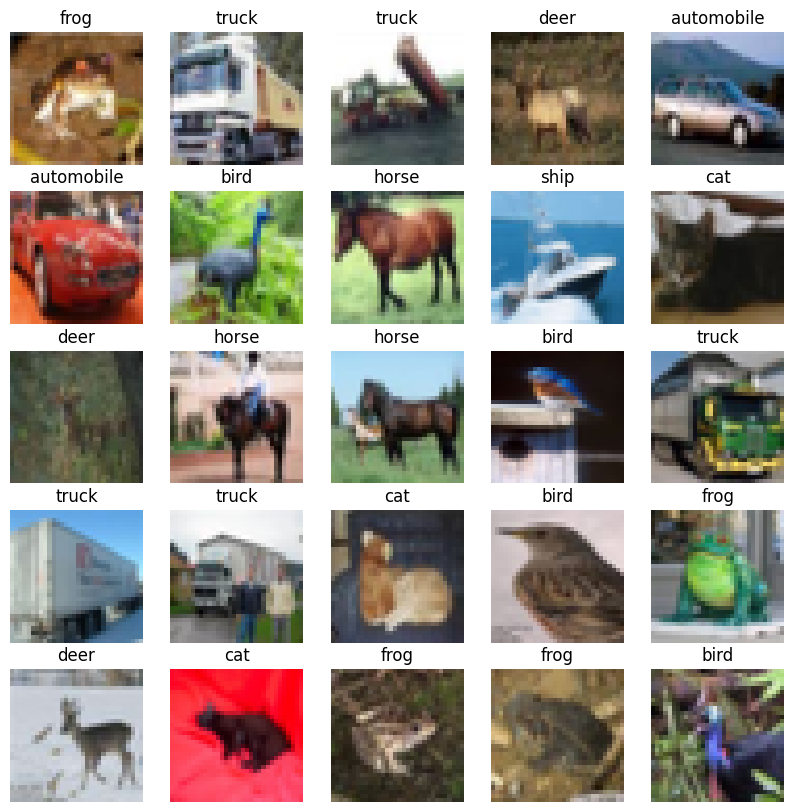

In [7]:
# Visualize the data
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i])
    plt.axis("off")
    plt.title(classes[int(y_train[i])])
plt.show()

In [8]:
# Hyperparameters
hp = {}
hp["image_size"] = 32
hp["num_channels"] = 3
hp["patch_size"] = 4
hp["num_patches"] = (hp["image_size"] // hp["patch_size"]) ** 2 # 64
hp["flat_patches_shape"] = (hp["num_patches"], hp["num_channels"] * hp["patch_size"] ** 2) # Transformed Input 64 * 8 * 8 * 3 = 3072
hp["embed_dim"] = 64 # Embedding Dimension

hp["batch_size"] = 25
hp["lr"] = 1e-4
hp["num_epochs"] = 10
hp["num_classes"] = 10
hp["mlp_dim"] = 128
hp["num_heads"] = 8
hp["num_layers"] = 12
hp["dropout_rate"] = 0.1
hp["class_names"] = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [9]:
(64, 3 * 4 ** 2), 64 * 4 * 4 * 3

((64, 48), 3072)

In [10]:
img = x_train[25]
label = y_train[25]
img.shape, label, hp["class_names"][int(label)]

<ipython-input-10-b0f0765578e8>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  img.shape, label, hp["class_names"][int(label)]


((32, 32, 3), array([6], dtype=uint8), 'frog')

<ipython-input-11-25af24870f18>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(hp["class_names"][int(label)])


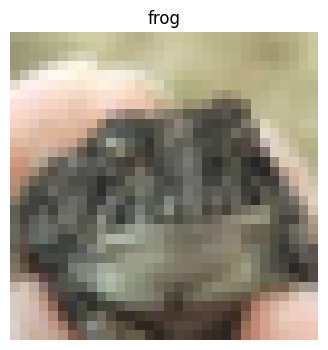

In [11]:
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis("off")
plt.title(hp["class_names"][int(label)])
plt.show()

In [12]:
img = tf.expand_dims(img, axis=0)
img.shape

TensorShape([1, 32, 32, 3])

In [13]:
tf.image.extract_patches(img,
                        (1, hp["patch_size"], hp["patch_size"], 1),
                        (1, hp["patch_size"], hp["patch_size"], 1),
                        [1, 1, 1, 1],
                        "VALID")

<tf.Tensor: shape=(1, 8, 8, 48), dtype=uint8, numpy=
array([[[[162, 164, 130, ..., 195, 191, 172],
         [185, 183, 144, ..., 251, 246, 234],
         [209, 206, 166, ..., 209, 208, 181],
         ...,
         [188, 185, 143, ..., 185, 175, 139],
         [179, 171, 131, ..., 171, 165, 125],
         [179, 171, 131, ..., 201, 198, 154]],

        [[167, 165, 137, ..., 249, 213, 201],
         [255, 248, 239, ..., 238, 201, 181],
         [250, 240, 222, ..., 240, 206, 189],
         ...,
         [192, 185, 143, ..., 105,  97,  83],
         [185, 174, 133, ..., 193, 190, 149],
         [183, 179, 138, ..., 191, 188, 148]],

        [[251, 217, 207, ..., 221, 185, 161],
         [236, 202, 184, ..., 155, 131, 115],
         [238, 196, 171, ..., 133, 136, 122],
         ...,
         [ 80,  78,  68, ...,  73,  71,  60],
         [ 99,  93,  74, ..., 225, 210, 198],
         [194, 190, 150, ..., 183, 180, 139]],

        ...,

        [[102, 105,  90, ...,  70,  70,  67],
         [1

In [14]:
class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, embed_dim, num_patches):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches = num_patches
        self.projection = layers.Dense(embed_dim)
        self.reshape = layers.Reshape((self.num_patches, self.embed_dim))  # Reshape to (batch_size, num_patches, embed_dim)

    def call(self, img):
        patches = tf.image.extract_patches(
            images=img,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patches = patches  # Shape will be (batch_size, num_patches, patch_size*patch_size*num_channels)
        patches = self.projection(patches)  # Project the patches into embedding space
        patches = self.reshape(patches)  # Reshape to (batch_size, num_patches, embed_dim)
        return patches


In [15]:
tf.expand_dims(img, axis=0)

<tf.Tensor: shape=(1, 1, 32, 32, 3), dtype=uint8, numpy=
array([[[[[162, 164, 130],
          [164, 167, 128],
          [169, 171, 131],
          ...,
          [184, 176, 137],
          [190, 186, 146],
          [202, 198, 161]],

         [[153, 151, 119],
          [158, 156, 120],
          [164, 163, 124],
          ...,
          [178, 171, 131],
          [189, 184, 143],
          [201, 198, 158]],

         [[157, 151, 120],
          [161, 156, 121],
          [164, 160, 122],
          ...,
          [178, 170, 131],
          [190, 186, 142],
          [202, 199, 156]],

         ...,

         [[214, 205, 193],
          [213, 193, 181],
          [213, 185, 174],
          ...,
          [240, 207, 193],
          [241, 206, 194],
          [242, 209, 196]],

         [[218, 209, 198],
          [209, 188, 176],
          [208, 180, 169],
          ...,
          [232, 195, 182],
          [236, 196, 185],
          [239, 200, 187]],

         [[216, 204, 197],
      

In [18]:
patch_test = PatchEmbedding(hp["patch_size"], hp["embed_dim"], hp["num_patches"])
patch_test(img).shape

TensorShape([1, 64, 64])

In [19]:
class ClassToken(layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

def mlp(x, cf):
  x = layers.Dense(cf["mlp_dim"], activation="gelu")(x)
  x = layers.Dropout(cf["dropout_rate"])(x)
  x = layers.Dense(cf["hidden_dim"])(x)
  x = layers.Dropout(cf["dropout_rate"])(x)
  return x

def transformer_encoder(x, cf):
  skip_1 = x
  x = layers.LayerNormalization()(x)
  x = layers.MultiHeadAttention(
      num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
  )(x, x)
  x = layers.Add()([x, skip_1])

  skip_2 = x
  x = layers.LayerNormalization()(x)
  x = mlp(x, cf)
  x = layers.Add()([x, skip_2])

  return x

In [20]:
def vit(cf):
  embeddings = PatchEmbedding(hp["patch_size"], hp["embed_dim"], hp["num_patches"])
  inputs = layers.Input(shape=(hp["image_size"], hp["image_size"], hp["num_channels"]))
  patches = embeddings(inputs)

  positions = tf.range(start=0, limit=hp["num_patches"], delta=1)
  pos_embedding = layers.Embedding(input_dim=hp["num_patches"], output_dim=hp["embed_dim"])(positions)
  print(f"Position Embeddings: {pos_embedding.shape}")
  encoded_patches = patches + pos_embedding
  print(f"Encoded Patches: {encoded_patches.shape}")

  # Adding Class Token
  token = ClassToken()(encoded_patches)
  print(f"Shape of the token tensor: {token.shape}")

  # Fix: Reshape to (batch_size, 1, embed_dim) to match encoded_patches
  token = tf.keras.layers.Reshape((1, hp["embed_dim"]))(token)

  x = layers.Concatenate(axis=1)([token, encoded_patches])  # Concatenate token with patches along the sequence dimension (axis=1)
  print(f"Shape of the concatenated tensor: {x.shape}")

  for _ in range(hp["num_layers"]):
    x = transformer_encoder(x, cf)

  print(x.shape)

  """ Classification Head """
  x = layers.LayerNormalization()(x)     ## (None, 257, 768)
  x = x[:, 0, :]
  x = layers.Dense(cf["num_classes"], activation="softmax")(x)

  model = tf.keras.Model(inputs, x)
  return model

In [21]:
config = {}
config["num_layers"] = 12
config["hidden_dim"] = 64
config["mlp_dim"] = 128
config["num_heads"] = 8
config["dropout_rate"] = 0.1
config["num_patches"] = 16
config["patch_size"] = 8
config["num_channels"] = 3
config["num_classes"] = 10
model = vit(config)

Position Embeddings: (64, 64)
Encoded Patches: (None, 64, 64)
Shape of the token tensor: (None, 1, 64)
Shape of the concatenated tensor: (None, 65, 64)
(None, 65, 64)


In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_embedding_3         │ (None, 64, 64)         │          3,136 │ input_layer[0][0]      │
│ (PatchEmbedding)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64)         │              0 │ patch_embedding_3[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class_token (ClassToken)  │ (None, 1, 64)          │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 1, 64)          │              0 │ class_token[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 65, 64)         │              0 │ reshape_4[0][0],       │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 65, 64)         │            128 │ concatenate[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 65, 64)         │        132,672 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 65, 64)         │              0 │ multi_head_attention[… │
│                           │                        │                │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 65, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 65, 128)        │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 65, 128)        │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 65, 64)         │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 65, 64)         │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 65, 64)         │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 65, 64)         │            128 │ add_2[0][0]            │
│ (LayerNormalization) 

 Total params: 1,797,962 (6.86 MB)

 Trainable params: 1,797,962 (6.86 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
y_train_one_hot = tf.one_hot(y_train, depth=hp["num_classes"])
y_test_one_hot = tf.one_hot(y_test, depth=hp["num_classes"])
y_train_one_hot.shape, y_test_one_hot.shape

(TensorShape([50000, 1, 10]), TensorShape([10000, 1, 10]))

In [24]:
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=hp["num_classes"])
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=hp["num_classes"])
y_train_one_hot.shape, y_test_one_hot.shape

((50000, 10), (10000, 10))

In [25]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test_one_hot))

In [26]:
# Set batch size
batch_size = 25  # Adjust as needed

# Shuffle, batch, and prefetch the datasets
train_dataset = (train_dataset
                 .shuffle(buffer_size=50000)  # Random shuffle with a buffer size of 50,000
                 .batch(batch_size)           # Batch the dataset
                 .prefetch(tf.data.experimental.AUTOTUNE))  # Prefetch data for optimal performance

test_dataset = (test_dataset
                .batch(batch_size)           # Batch the dataset
                .prefetch(tf.data.experimental.AUTOTUNE))  # Prefetch data for optimal performance


In [27]:
# Get an iterator for the dataset using the built-in Python `iter` function.
img_iter = iter(train_dataset)

# Get the next batch of data
img_batch = next(img_iter)

# Access a single image (assuming the batch size is 25)
img = img_batch[0][0]  # First element of the first batch

# Get the shape of the image
img.shape, tf.squeeze(img_batch[1][0]).shape

(TensorShape([32, 32, 3]), TensorShape([10]))

In [28]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
              metrics=["accuracy"])

In [29]:
# Fit the model
history = model.fit(train_dataset,
                    epochs=hp["num_epochs"],
                    validation_data=test_dataset)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 140s 34ms/step - accuracy: 0.2223 - loss: 2.0718 - val_accuracy: 0.3886 - val_loss: 1.6416
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 63s 32ms/step - accuracy: 0.4256 - loss: 1.5689 - val_accuracy: 0.4823 - val_loss: 1.4141
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 85s 33ms/step - accuracy: 0.5085 - loss: 1.3638 - val_accuracy: 0.5372 - val_loss: 1.2977
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 65s 33ms/step - accuracy: 0.5495 - loss: 1.2542 - val_accuracy: 0.5451 - val_loss: 1.2508
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - accuracy: 0.5799 - loss: 1.1776 - val_accuracy: 0.5678 - val_loss: 1.2198
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - accuracy: 0.5985 - loss: 1.1264 - val_accuracy: 0.5689 - val_loss: 1.2125
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - accuracy: 0.6150 - loss: 1.0782 - val_accuracy: 0.5844 - val_loss: 1.1789
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.6339 

In [30]:
model.evaluate(x_test, y_test_one_hot)

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6021 - loss: 1.1372


[1.1298166513442993, 0.6092000007629395]

<Axes: >

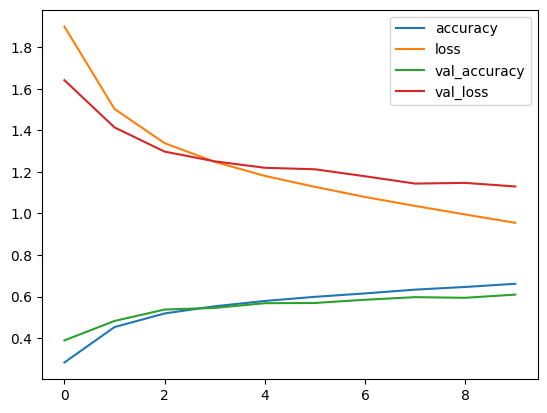

In [34]:
import pandas as pd

# Create a DataFrame from the history dictionary
df = pd.DataFrame(history.history)

# Call the plot method on the DataFrame
df.plot()

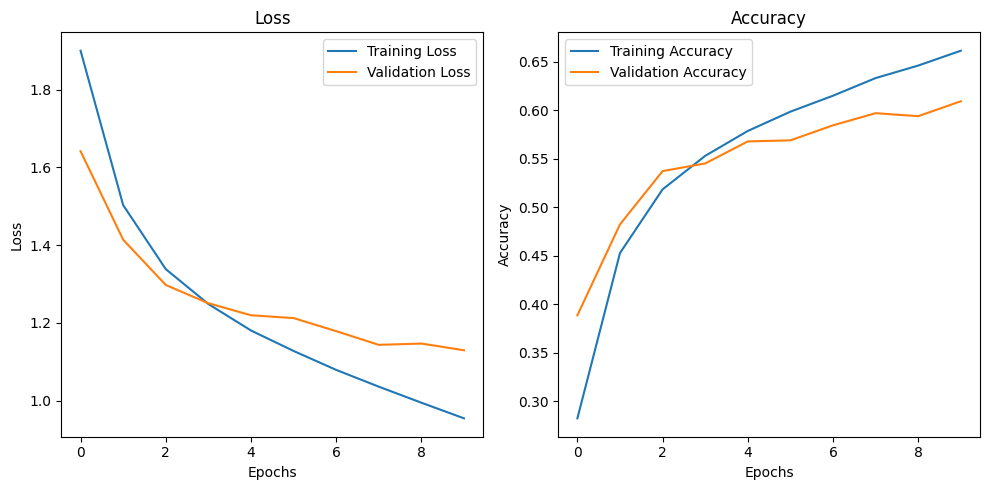

In [35]:
def plot_loss_curves(history):
    # Extract training and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Extract training and validation accuracy
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_loss_curves(history)

In [36]:
model.save("VIT model_0_epochs_10.h5")

In [37]:
model.evaluate(x_test, y_test_one_hot)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6021 - loss: 1.1372


[1.1298166513442993, 0.6092000007629395]

In [39]:
pred = model.predict(x_test)
pred = tf.argmax(pred, axis=1)
pred[:4]

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 1, 8, 8])>

In [40]:
len(y_test)

10000

In [42]:
# Convert pred to NumPy array to enable comparison with y_test
pred = pred.numpy()
# Reshape y_test to match the shape of pred
y_test = y_test.reshape(-1)
# Calculate the number of incorrect predictions
incorrect_predictions = sum(pred != y_test)
print(f"Number of incorrect predictions: {incorrect_predictions}")

Number of incorrect predictions: 3908
